# <span style="color:blue"> MBA em Ciência de Dados</span>
# <span style="color:blue">Aprendizado Dinâmico</span>

## <span style="color:blue">Avaliação Final</span>

### Aluno: Benicio Ramos Magalhães

**Material Produzido por Cibele Russo**<br>
**Cemeai - ICMC/USP São Carlos**

##### Para esta avaliação, você deve entregar três arquivos:
    ● um arquivo de dados em .csv com a base resultante das análises
    ● um relatório em .ipynb com suas análises comentadas
    ● um arquivo .pdf gerado a partir do .ipynb

##### Os dados de casos confirmados e mortes diárias por COVID-19 nos Estados Unidos estão disponíveis no arquivo covid19USA.csv. 

In [31]:
#bibliotecas
import six
import sys
import numpy as np
import pandas as pd
from pylab import rcParams
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from keras.models import Sequential
sys.modules['sklearn.externals.six'] = six
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import warnings; warnings.simplefilter('ignore')
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Exercício 1

#### Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os dados estão corretos e realizar algum procedimento necessário caso haja dados faltantes. 

In [2]:
#leitura dos dados estabelecendo um índice por datas
data = pd.read_csv('.\covid19USA.csv',index_col='date',parse_dates=True)
data.head()

,confirmed,deaths
date,,
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


 ___________________________________________________________
|                    Verificação de dados                   |
|___________________________________________________________|
|Início:----------------------------| 2020-01-01 00:00:00 --|
|Fim:-------------------------------| 2020-09-03 00:00:00 --|
|Tipo de dado do índice:------------| datetime64[ns] -------|
|Tamanho da base original:----------| 247 ------------------|
|Tamanho esperado para o intervalo:-| 247 ------------------|
|Dados Faltantes em confirmed:------| 0 --------------------|
|Dados Faltantes em deaths:---------| 0 --------------------|
|Dados Zerados em deaths:-----------| 61 -------------------|
|Dados Zerados em deaths > 29-02:---| 1 --------------------|
|___________________________________________________________|

Verificando dados zerados com data maior que 29-02:
date
2020-03-20    0
Name: deaths, dtype: int64


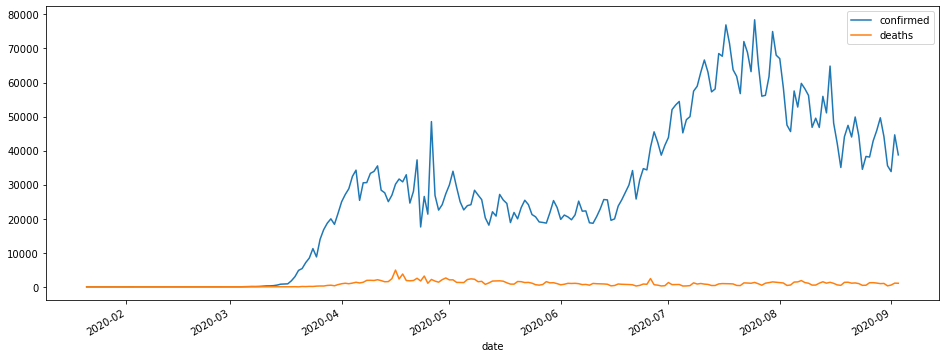

In [3]:
#verificando se os dados estão corretos

#checando intervalos de datas e tamanho do da base:
print(' ___________________________________________________________')
print('|                    Verificação de dados                   |')
print('|___________________________________________________________|')
print('|Início:----------------------------|',data.index.min(),'--|')
print('|Fim:-------------------------------|',data.index.max(),'--|')
print('|Tipo de dado do índice:------------|',data.index.dtype,'-------|')
print('|Tamanho da base original:----------|',len(data),'------------------|')
print('|Tamanho esperado para o intervalo:-|',len(pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')),'------------------|')

#verifcando se temos dados faltantes:
print('|Dados Faltantes em confirmed:------|',len(data[data['confirmed'].isnull()]),'--------------------|')
print('|Dados Faltantes em deaths:---------|',len(data[data['deaths'].isnull()]),'--------------------|')
print('|Dados Zerados em deaths:-----------|',len(data[data['deaths']==0]),'-------------------|')
print('|Dados Zerados em deaths > 29-02:---|',len(data[data['deaths']==0].iloc[60:]),'--------------------|')
print('|___________________________________________________________|')

print()
print('Verificando dados zerados com data maior que 29-02:')
print(data[data['deaths']==0]['deaths'].iloc[60:])
#printando os dados:
rcParams['figure.figsize'] = 16, 6
data[data['confirmed']>0].plot();

    Conforme observamos na base de dados, não tivemos ocorrências de valores faltantes (NaN). Temos um base de mortes com valores zerados até o dia 29-02, na qual tratando-se de um registro global desde o surgimento da pandemia, possivelmente  não tivemos ocorrências de mortes nos EUA nesse período. Após essa data, temos apenas uma ocorrência de mortes zeradas  na base, que ocorreu no dia 20-03-2020. Os valores zerados não permitem gerarmos um modelo com sazonalidade multiplicativa, então temos que considerar essa informação na modelagem.
    
    Possivelmente o valor de 20-03-2020 trata-se de um erro de registro, porém, temos que levar em consideração a  possibilidade de que esses registros possam ter sido compensados em outro dia, como, por exemplo, em 21-03-2020, que apresenta um número bem maior de ocorrências do que os dias anteriores.
    
    Como estratégia de análise, decidimos por não inserir dados nessa data, logo, no momento da modelagem, iremos filtrar as ocorrências como mortes zeradas, ciente de que esse dia não será contabilizado na modelagem final para uma previsão com sazonalidade multiplicativa.

### Exercício 2

#### Proponha uma decomposição dos dados de mortes em tendência e sazonalidade. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente brevemente os resultados.

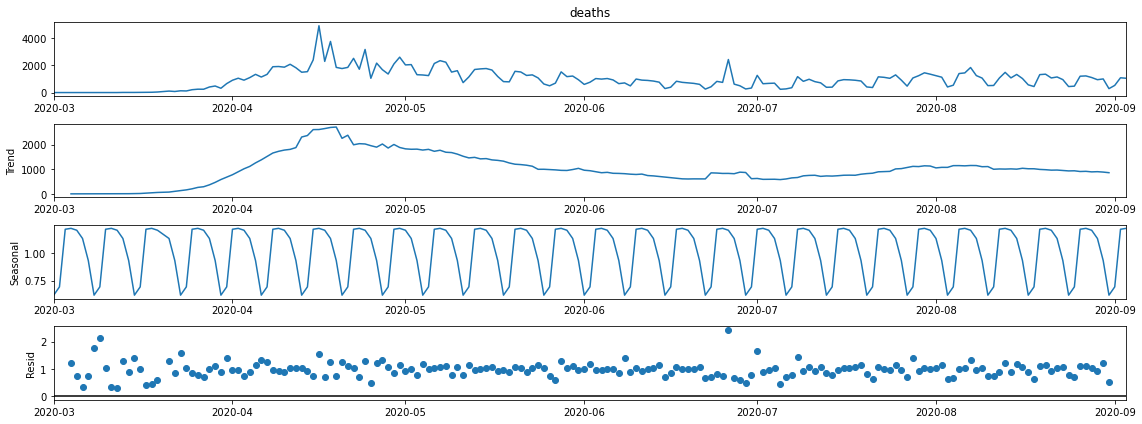

In [4]:
#decomposição dos dados de mortes em tendência e sazonalidade:
decomposicao = seasonal_decompose(data[data['deaths']>0]['deaths'],model='multiplicative', period=7) #filtrando mortes > 0
fig = decomposicao.plot()

In [5]:
#testando a estacionariedade com Dickey-Fuller
result = adfuller(data['deaths'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.389673
p-value: 0.144672
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


###### Análise de tendência:
        É possível observar uma tendência crescente no período de abril. A curva segue depois com uma tendência decrescente até meados de junho. No final de junho, temos um pequeno período de elevação, seguido logo de queda. Depois desse  período a tendência fica muito menos evidente, praticamente sugerindo uma estacionaridade, porém, os testes de Dickey-Fuller realizados anteriormente com p-valor maior que 0.05, sugere que rejeitemos a hipótese de estacionariedade na série.

###### Análise de sazonalidade:
        Podemos observar ciclos semanais que provavelmente são explicadas pela sistemática de notificações, onde os dados ficam acumulados para cálculo no ínicio da semana e são sumarizados e apresentados mais para o meio da semana. Com relação ao tipo de sazonalidade, o gráfico apresenta algumas variações ao longo da série temporal, principalmente nos períodos de tendência crescente, portanto, consideramos mais adequada representarmos a sazonalidade como sendo do tipo  multiplicativa.

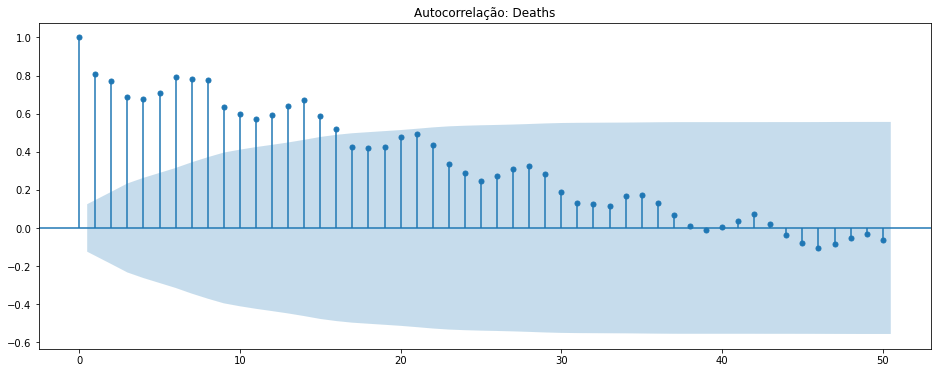

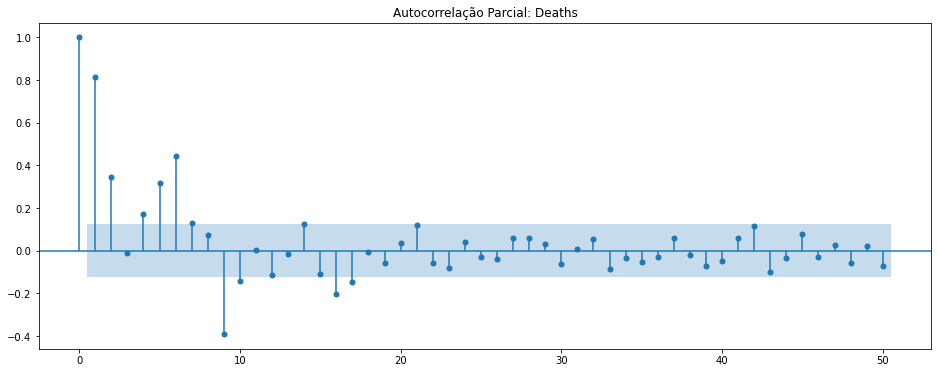

In [6]:
#gráficos de autocorrelação e autocorrelação parcial
fig = plot_acf(data['deaths'],title='Autocorrelação: Deaths',lags=50)
fig = plot_pacf(data['deaths'],title='Autocorrelação Parcial: Deaths',lags=50)

###### Análise de autocorrelação:
        Podemos observar que a correlação entre a série original até a série com atraso lag=16 são bastante significativas  pois encontram-se maiores que o intervalo de confiança (área azul), portanto, precisamos levá-las em consideração  durante a modelagem. Notamos também que há presença de sazonalidade nos dados, apresentando vales/picos em ciclos de 7 dias.
        
###### Análise de autocorrelação parcial:  
        Podemos verificar que a partir do lag=3 a correlação cai bastante, apresentando valores por volta 0.4. Mesmo as  correlações não sendo tão altas, elas ainda são importantes para o modelo, pois apresentam-se fora do intervalo de  confiança.

### Exercício 3

#### Divida a base em treino e teste, com 21 observações na base de teste. Você deverá apresentar em distintas colunas na mesma base de dados que será entregue: 

          ● Os dados originais de casos confirmados e mortes. 
    
          ● As previsões de Holt e Holt Winters para a variável mortes. 
    
          ● As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido para a variável mortes. Identifique as componentes desse melhor modelo (por exemplo, “o modelo tem uma componente autorregressiva não sazonal de ordem.., uma componente de médias móveis não-sazonal de ordem.., etc). 
    
          ● As previsões obtidas por um modelo de redes dinâmicas para a variável mortes. 

In [7]:
#definindo uma semente (42! - the answer to everything)
np.random.seed(42)

#dividindo a base em treino e teste:
train = data.iloc[:226]
test = data.iloc[226:]

print('Base de treino:',len(train),'observações.')
print('Base de teste:',len(test),'observações.')

Base de treino: 226 observações.
Base de teste: 21 observações.


In [8]:
#métodos de suavização holt e holt-winters para a variável mortes:

#treinamento e predição pelo método de Holt
adjustH = ExponentialSmoothing(train[train['deaths']>0]['deaths'],trend='mul').fit() #filtro de mortes > 0
predictH = adjustH.forecast(21).rename('Previsão Holt')
predictH.index = data.index[226:]

#treinamento e predição pelo método de Holt-Winters
adjustHW = ExponentialSmoothing(train[train['deaths']>0]['deaths'],trend='mul',
                                seasonal='mul',seasonal_periods=7).fit() #filtro de mortes > 0
predictHW = adjustHW.forecast(21).rename('Previsão Holt-Winters')
predictHW.index = data.index[226:]

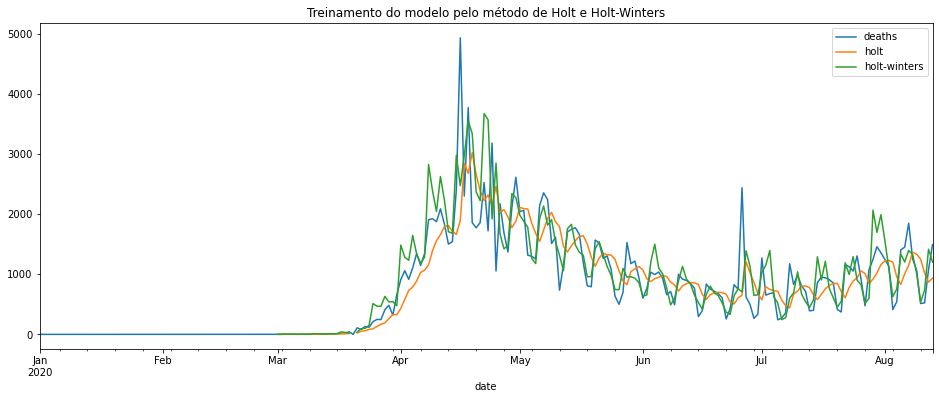

In [9]:
#imprimindo dados de treinamento modelados pelo método de holt e holt-winters
train['holt'] = adjustH.fittedvalues;
train['holt-winters'] = adjustHW.fittedvalues;

fig = train[['deaths','holt','holt-winters']].plot(figsize=(16,6),
                                                   title='Treinamento do modelo pelo método de Holt e Holt-Winters')

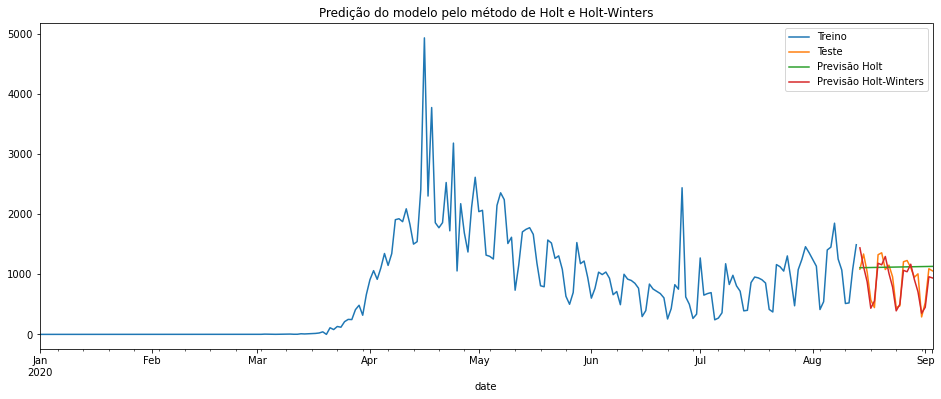

In [10]:
#imprimindo dados com a predição realizada pelo método de holt e holt-winters
test['holt'] = predictH
test['holt-winters'] = predictHW

train['deaths'].plot(legend=True,label='Treino',title='Predição do modelo pelo método de Holt e Holt-Winters')
test['deaths'].plot(legend=True,label='Teste',figsize=(16,6))
predictH.plot(legend=True,label='Previsão Holt')
fig = predictHW.plot(legend=True,label='Previsão Holt-Winters')

In [11]:
# aplicando stepwise para selecionar o melhor modelo SARIMA
auto_arima(train['deaths'],seasonal=True,m=7).summary()

stepwise_fit = auto_arima(train['deaths'], start_p=0, start_q=0,max_p=6,max_q=3,m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          supress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=3418.337, BIC=3432.001, Fit time=0.149 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=3418.463, BIC=3425.295, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=3353.998, BIC=3367.663, Fit time=0.248 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=3349.966, BIC=3363.630, Fit time=0.372 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=3306.510, BIC=3323.591, Fit time=0.762 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=3340.881, BIC=3354.546, Fit time=0.304 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=3304.675, BIC=3325.171, Fit time=1.279 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=3300.207, BIC=3324.120, Fit time=1.461 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 2, 7); AIC=3306.376, BIC=3326.873, Fit time=1.192 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  226
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 7)   Log Likelihood               -1633.119
Date:                            Wed, 16 Sep 2020   AIC                           3284.239
Time:                                    13:53:32   BIC                           3314.984
Sample:                                         0   HQIC                          3296.648
                                            - 226                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.6011     14.299     -0.392      0.695     -33.626      22.424
ar.L1          0.8173      0.071     11.520      0.000       0.678       0.956
ar.L2         -0.4568      0.089     -5.133      0.000      -0.631      -0.282
ar.L3         -0.4185      0.064     -6.533      0.000      -0.544      -0.293
ma.L1         -1.5598      0.080    -19.531      0.000      -1.716      -1.403
ma.L2          1.2980      0.113     11.448      0.000       1.076       1.520
ma.L3         -0.3483      0.074     -4.689      0.000      -0.494      -0.203
ar.S.L7       -0.0497      0.056     -0.881      0.378      -0.160       0.061
sigma2      1.318e+05   5703.856     23.108      0.000    1.21e+05    1.43e+05
===================================================================================
Ljung-Box (Q):                       51.68   Jarque-Bera (JB):              6750.13
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):             464.93   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### Descrição do modelo selecionado: SARIMAX(3, 1, 3)x(1, 0, 0, 7)

    - Componente não sazonal autorregressiva de ordem 3
    - Componente não sazonal integrado de ordem 1
    - Componente não sazonal de médias móveis de ordem 3
    - Componente sazonal autorregressiva de primeira ordem com período 7
    - Sem componente sazonal integrada
    - Sem componente sazonal de média móvel

In [12]:
#treinamento utilizando o modelo SARIMA identificado pelo stepwise
adjustSARIMA = SARIMAX(train['deaths'],order=(3,1,3),seasonal_order=(1,0,0,7)).fit()
adjustSARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             deaths   No. Observations:                  226
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 7)   Log Likelihood               -1631.614
Date:                            Wed, 16 Sep 2020   AIC                           3279.228
Time:                                    13:53:33   BIC                           3306.557
Sample:                                01-01-2020   HQIC                          3290.258
                                     - 08-13-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8179      0.063     13.040      0.000       0.695       0.941
ar.L2         -0.4578      0.079     -5.788      0.000      -0.613      -0.303
ar.L3         -0.4142      0.056     -7.403      0.000      -0.524      -0.305
ma.L1         -1.5655      0.071    -22.156      0.000      -1.704      -1.427
ma.L2          1.2993      0.102     12.737      0.000       1.099       1.499
ma.L3         -0.3508      0.066     -5.313      0.000      -0.480      -0.221
ar.S.L7       -0.0502      0.045     -1.126      0.260      -0.138       0.037
sigma2      1.151e+05   3894.620     29.560      0.000    1.07e+05    1.23e+05
===================================================================================
Ljung-Box (Q):                       51.51   Jarque-Bera (JB):              6746.95
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):           54463.55   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#predição utilizando o modelo SARIMA identificado pelo stepwise
start = len(train)
end = len(train) + len(test)-1
predict_SARIMA = adjustSARIMA.predict(start=start,end=end,
                                      dynamic=False,typ='levels').rename('Previsões SARIMA(3, 1, 3)x(1, 0, 0, 7)')
predict_SARIMA.index = test.index

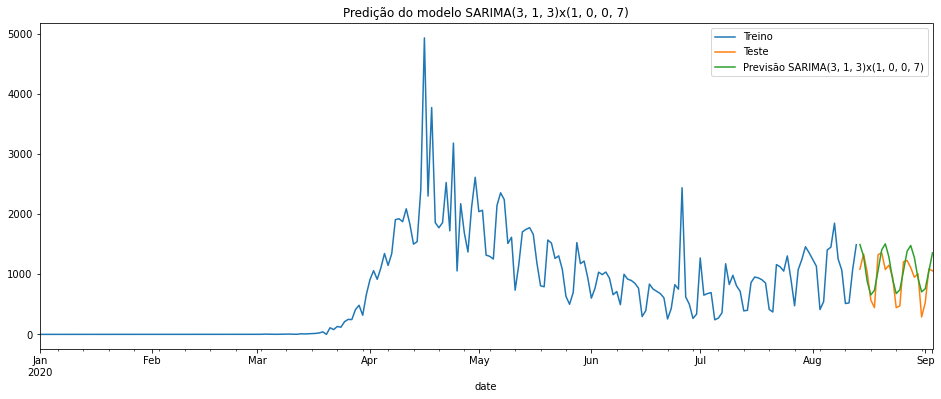

In [14]:
#imprimindo dados com a predição realizada pelo SARIMA
train['sarima'] = adjustSARIMA.fittedvalues
test['sarima'] = predict_SARIMA

train['deaths'].plot(legend=True,label='Treino',title='Predição do modelo SARIMA(3, 1, 3)x(1, 0, 0, 7)')
test['deaths'].plot(legend=True,label='Teste',figsize=(16,6))
fig = predict_SARIMA.plot(legend=True,label='Previsão SARIMA(3, 1, 3)x(1, 0, 0, 7)')

 ____________________________________________________________________________
|                     Padronização dos dados de treino:                      |
|____________________________________________________________________________|
|Intervalo de dados de treino:  | 0.0  -  1.0                                |
|____________________________________________________________________________|
|Intervalo de dados de teste:   | 0.0588474025974026  -  0.27516233766233766 |
|____________________________________________________________________________|


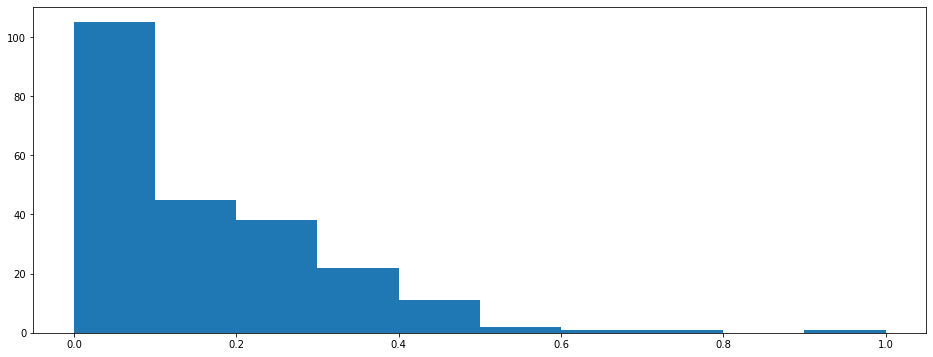

In [15]:
# padronizando os dados para aplicar modelo de redes dinâmicas
scaler = MinMaxScaler().fit(train['deaths'].values.reshape(-1,1))
scaled_train = scaler.transform(train['deaths'].values.reshape(-1,1))
scaled_test = scaler.transform(test['deaths'].values.reshape(-1,1))

print(' ____________________________________________________________________________')
print('|                     Padronização dos dados de treino:                      |')
print('|____________________________________________________________________________|')
print('|Intervalo de dados de treino:  |',scaled_train.min(),' - ',scaled_train.max(),'                               |')
print('|____________________________________________________________________________|')
print('|Intervalo de dados de teste:   |',scaled_test.min(),' - ',scaled_test.max(),'|')
print('|____________________________________________________________________________|')

fig = plt.hist(scaled_train)

In [16]:
#definindo o gerador
generator = TimeseriesGenerator(scaled_train, scaled_train, length=7, batch_size=1) #lote de tamanho 7 devido a sazonalidade

print('Tamanho das amostras de treino:',len(scaled_train))
print('Tamanho do gerador dividido por lotes:',len(generator))

X,y = generator[0] #aparência do primeiro lote

print()
print('Dados do primeiro lote:',X.flatten())
print('Predição do primeiro lote:',y.flatten())

Tamanho das amostras de treino: 226
Tamanho do gerador dividido por lotes: 219

Dados do primeiro lote: [0. 0. 0. 0. 0. 0. 0.]
Predição do primeiro lote: [0.]


In [17]:
#modelo de redes dinâmicas LSTM (Long Short-Term Memory)
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(7,1))) #camada LSTM com 100 neurônios
model.add(Dense(1)) #camada de saída com 1 output
model.compile(optimizer='adam',loss='mse') #função de perda de erro quadrático médio
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
#ajustando o modelo
model.fit_generator(generator, epochs=100) #com 100 interações

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0107
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0083
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0087
Epoch 5/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0076
Epoch 6/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 7/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0079
Epoch 8/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 9/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 10/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 11/100
219/219 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 12/100
219/219

In [19]:
#salvando o modelo gerado
model.save('modelo_rnn_lstm.h5') 
model.history.history.keys()

dict_keys(['loss'])

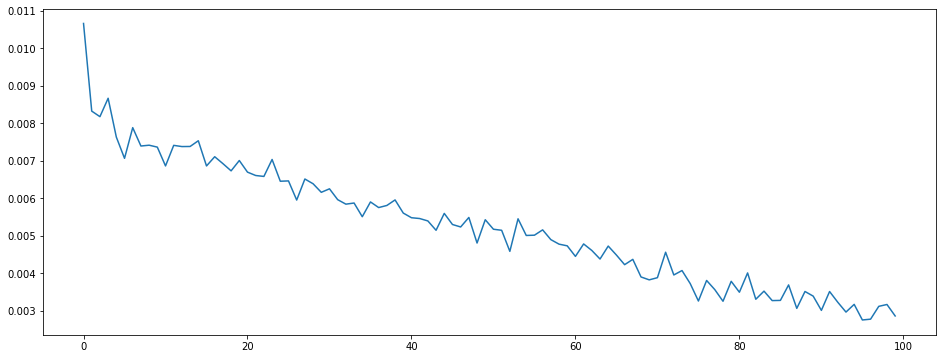

In [20]:
#plotando um gráfico de perda, resultante das iterações do ajuste do modelo
loss_per_epoch = model.history.history['loss']
fig = plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [21]:
#realizando a previsão com os dados de teste
test_predictions = []
first_batch = scaled_train[-7:]
current_batch = first_batch.reshape((1,7,1))

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:],[[current_prediction]],axis=1)

In [22]:
#voltando a padronização dos dados para treino e para as predições dos testes
train_model = scaler.inverse_transform(scaled_train)
true_predictions = scaler.inverse_transform(test_predictions)

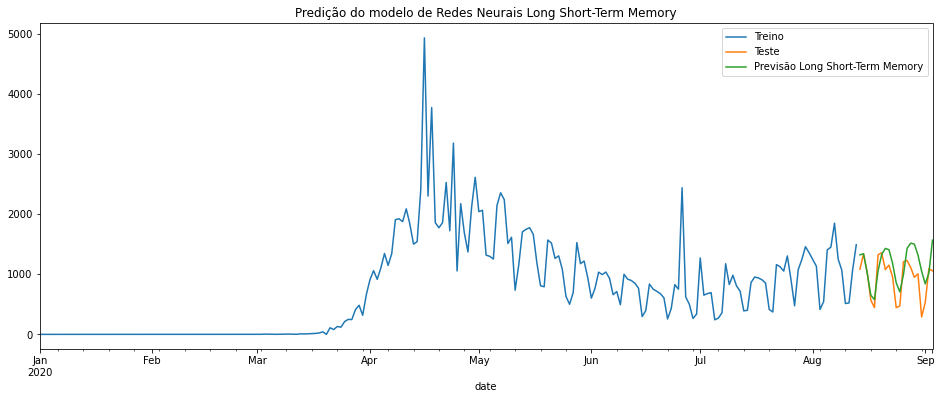

In [23]:
#imprimindo dados com a predição realizada pelas redes dinâmicas lstm
train['lstm'] = train_model #copiando a mesma base de treino na previsão LSTM para evitar deixar tudo vazio.
test['lstm'] = true_predictions
train['deaths'].plot(legend=True,label='Treino',title='Predição do modelo de Redes Neurais Long Short-Term Memory')
test['deaths'].plot(legend=True,label='Teste',figsize=(16,6))
fig = test['lstm'].plot(legend=True,label='Previsão Long Short-Term Memory')

### Exercício 4

#### Utilize o erro quadrático médio e erro absoluto médio para comparar as previsões obtidas com as observações da base de teste.

In [30]:
#utilizando erro quadrático médio e erro absoluto médio para comparação 

#comparação entre modelos usando MSE
print('  _____________________________________________')
print(' |               Avalição MSE                  |')
print(' | ____________________________________________|')
print(' | HOLT:                           |', '%.2f' % mean_squared_error(test['deaths'],test['holt']),'|')
print(' | HOLT-WINTERS:                   |','%.2f' % mean_squared_error(test['deaths'],test['holt-winters']),' |')
print(' | SARIMA(3, 1, 3)x(1, 0, 0, 7):   |','%.2f' % mean_squared_error(test['deaths'],test['sarima']),' |')
print(' | LSTM:                           |','%.2f' % mean_squared_error(test['deaths'],test['lstm']),'|')
print(' |_________________________________|___________|')
print()
print()
#comparação entre modelos usando MAE
print('  _____________________________________________')
print(' |               Avalição MAE                  |')
print(' | ____________________________________________|')
print(' | HOLT:                           |','%.2f' % mean_absolute_error(test['deaths'],test['holt']),'   |')
print(' | HOLT-WINTERS:                   |','%.2f' % mean_absolute_error(test['deaths'],test['holt-winters']),'   |')
print(' | SARIMA(3, 1, 3)x(1, 0, 0, 7):   |','%.2f' % mean_absolute_error(test['deaths'],test['sarima']),'   |')
print(' | LSTM:                           |','%.2f' % mean_absolute_error(test['deaths'],test['lstm']),'   |')
print(' |_________________________________|___________|')

  _____________________________________________
 |               Avalição MSE                  |
 | ____________________________________________|
 | HOLT:                           | 139513.11 |
 | HOLT-WINTERS:                   | 27429.52  |
 | SARIMA(3, 1, 3)x(1, 0, 0, 7):   | 61597.01  |
 | LSTM:                           | 105252.02 |
 |_________________________________|___________|


  _____________________________________________
 |               Avalição MAE                  |
 | ____________________________________________|
 | HOLT:                           | 266.21    |
 | HOLT-WINTERS:                   | 144.38    |
 | SARIMA(3, 1, 3)x(1, 0, 0, 7):   | 211.41    |
 | LSTM:                           | 265.77    |
 |_________________________________|___________|


Temos as seguintes definições para MSE e MAE:

###### MSE (Mean Square Error):
$$
{MSE} = {{1 \over N}  \sum_{i=1}^N{(y_i - \hat{y_i})^2}}
$$

###### MAE (Mean Absolute Error):
$$
{MAE} = {{1 \over N}  \sum_{i=1}^N{|y_i - \hat{y_i}|}}
$$

onde 
   
   ${y_i}$ = valor real da variável dependente
   
   $\hat{y_i}$ = valor previsto
   
   ${N}$ = tamanho da amostra
   
   
Essas medidas são bem diretas, sendo basicamente uma somatória da diferença entre o valor real e o valor previsto. Isso mostra o quanto nossos resultados previstos divergem do valor real. Um MSE mais alto significa que os valores estão muito dispersos, portanto, quanto menor o valor desta métrica, melhor, refletindo assim em um bom ajuste do modelo. Um ponto de atenção que devemos ter é que valores muito pequenos para MSE podem indicar um overfitting dos dados, mas esse não aparenta ser o caso da nossa análise.

Neste caso, para avaliarmos o melhor modelo, estamos comparando os valores obtidos e dando preferência para a avaliação onde tivemos o menor valor, tanto no MSE quanto no MAE. Assim, o modelo com a melhor previsão foi de <b>Holt-Winters</b>.

### Exercício 5

#### Considere o método que produziu a melhor previsão para os dados de teste e faça a previsão para mais 14 dias (além das observações da base de dados). Essa previsão pode ser apresentada com um gráfico nos arquivos .ipynb e .pdf. 

In [25]:
#treinamento e predição pelo método de Holt-Winters utilizando toda a base de dados
adjustHW_final = ExponentialSmoothing(data[data['deaths']>0]['deaths'],trend='mul',seasonal='mul',seasonal_periods=7).fit()
predictHW_final = adjustHW_final.forecast(14).rename('Holt-Winters Forecast')

In [26]:
#unificando as bases de dados em uma única
data_forecast = data

#inserindo dados de treino e teste das previsões anteriores
data_forecast['Holt'] = train['holt']
data_forecast['Holt'].loc[226:247] = test['holt']
data_forecast['Holt-Winters'] = train['holt-winters']
data_forecast['Holt-Winters'].loc[226:247] = test['holt-winters']
data_forecast['SARIMA'] = train['sarima']
data_forecast['SARIMA'].loc[226:247] = test['sarima']
data_forecast['Long Short-Term Memory'] = train['lstm']
data_forecast['Long Short-Term Memory'].loc[226:247] = test['lstm']

#inserindo índices novos para o forecast de 14 dias
idx = pd.date_range(data_forecast.index[-1], periods=15, freq='1d')[1:]
predictHW_final.index = idx
predictHW_final = pd.DataFrame(predictHW_final)
data_forecast = data_forecast.append(predictHW_final)
data_forecast['Holt-Winters Forecast'].iloc[:247] = adjustHW_final.fittedvalues

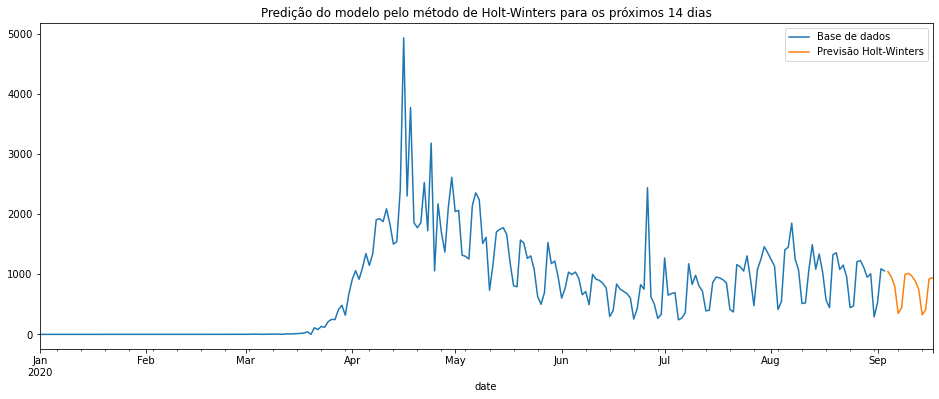

In [27]:
#imprimindo dados com a predição realizada pelo método de holt-winters para os próximos 14 dias
data['deaths'].plot(legend=True,label='Base de dados',
                    title='Predição do modelo pelo método de Holt-Winters para os próximos 14 dias')
fig = data_forecast['Holt-Winters Forecast'].iloc[247:].plot(legend=True,label='Previsão Holt-Winters')

In [28]:
#printando os resultados da análise em um arquivo csv
data_forecast.to_csv('Benicio-avaliacao-ad-resultados-analises.csv')
data_forecast.iloc[220:]

,confirmed,deaths,Holt,Holt-Winters,SARIMA,Long Short-Term Memory,Holt-Winters Forecast
2020-08-08,58150.0,1252.0,1366.650765,1326.721106,1352.487553,1252.000000,1326.721106
2020-08-09,56221.0,1069.0,1332.275704,1012.093751,1073.541851,1069.000000,1012.093751
2020-08-10,46847.0,513.0,1251.526256,537.116406,826.008751,513.000000,537.116406
2020-08-11,49530.0,523.0,1022.524152,732.100044,877.059363,523.000000,732.100044
2020-08-12,46813.0,1076.0,867.790211,1415.459159,991.725796,1076.000000,1415.459159
2020-08-13,55941.0,1490.0,933.534854,1201.557220,1316.812681,1490.000000,1201.557220
2020-08-14,51094.0,1083.0,1107.925242,1438.009011,1493.331715,1321.673788,1438.009011
2020-08-15,64838.0,1336.0,1109.017561,1125.912189,1300.243922,1339.709354,1024.503956
2020-08-16,48085.0,1035.0,1110.110956,873.035486,883.135011,1020.582578,867.578198
2020-08-17,42104.0,571.0,1111.205430,434.121146,654.833988,653.260085,464.606771
